# DATA

We use data from the **ATLAS/ICESat-2 L3B Gridded Antarctic and Arctic Land Ice Height Change V004** data collection (**ATL15**) to calculate the average yearly ice thickness change [in meters ice equivalent]. Note that the dataset provides surface elevation changes which need to be converted into total thickness changes. We combine the following 1 km resolution data sets to cover the entirety of Ross Ice Shelf:
- ATL15_A3_0325_01km_004_05.nc (1.2 GB) where A3 contains *Ross West* (lower left on map with 0° meridian up).
- ATL15_A4_0325_01km_004_05.nc (2.5 GB) where A4 contains *Ross East* (lower right on map with 0° meridian up).

In [NASA's Earthdata Search]() look for *ATLAS/ICESat-2 L3B* to find related data sets.

Characteristics:
- Resolution: 1 km grid resolution (the highest available)
- Temporal coverage: 01/01/2019 (start) - 31/12/2024 (end) -> 5 year average, 4 time slices per year
- Nominal value: height change is relative to 2020

Conversion:
- Rignot et al. uses the conversion from elevation to thickness change ratetechnique from **H. D. Pritchard et al., Antarctic ice-sheet loss driven by basal melting of ice shelves. Nature
484, 502 (2012). doi:10.1038/nature10968** -> elevation to thickness chnage rate
    - uses hydrostatic equilibrium to convert change in freeboard to change in thickness

In [1]:
import numpy as np
import pandas as pd

# xarray >= 2024.10.0 for data tree
# e.g. contained in bo4ais_env
import xarray as xr
import torch
import matplotlib.pyplot as plt

In [2]:
path_a3 = "/home/kim/data/icesat2/ATL15_A3_0325_01km_004_05.nc"
path_a4 = "/home/kim/data/icesat2/ATL15_A4_0325_01km_004_05.nc"

# NOTE: This does not work
# a3 = xr.open_dataset(path_a3)
# NOTE: These nc files can only be opened as a datatree
a3_tree = xr.open_datatree(path_a3)
a4_tree = xr.open_datatree(path_a4)

# Now make DataSet
a3 = xr.Dataset(a3_tree.delta_h)
a4 = xr.Dataset(a4_tree.delta_h)

print(a3.data_vars)
print(a4.data_vars)

Data variables:
    Polar_Stereographic  int8 1B ...
    ice_area             (time, y, x) float32 278MB ...
    delta_h              (time, y, x) float32 278MB ...
    delta_h_sigma        (time, y, x) float32 278MB ...
    data_count           (time, y, x) float32 278MB ...
    misfit_rms           (time, y, x) float32 278MB ...
    misfit_scaled_rms    (time, y, x) float32 278MB ...
Data variables:
    Polar_Stereographic  int8 1B ...
    ice_area             (time, y, x) float32 612MB ...
    delta_h              (time, y, x) float32 612MB ...
    delta_h_sigma        (time, y, x) float32 612MB ...
    data_count           (time, y, x) float32 612MB ...
    misfit_rms           (time, y, x) float32 612MB ...
    misfit_scaled_rms    (time, y, x) float32 612MB ...


In [20]:
a3.delta_h

<xarray.DataArray 'delta_h' (time: 25, y: 1391, x: 2001)> Size: 278MB
[69584775 values with dtype=float32]
Coordinates:
  * x        (x) float64 16kB -2e+06 -1.999e+06 -1.998e+06 ... -2e+03 -1e+03 0.0
  * y        (y) float64 11kB -1.39e+06 -1.389e+06 -1.388e+06 ... -1e+03 0.0
  * time     (time) datetime64[ns] 200B 2019-01-01T06:00:00 ... 2024-12-31T18...
Attributes:
    units:         meters
    dimensions:    time,y,x
    datatype:      float32
    description:   Height change relative to the datum (Jan 1, 2020) surface
    long_name:     height change  at 1 km
    source:        ATBD section 3.4
    grid_mapping:  Polar_Stereographic

# Subset Ross coords

In [3]:
x_min = - 600_000
x_max = 400_000
# y_min = - 1_400_000
# Increase so both have same y range and merge is easier
y_min = - 1_390_000
y_max = - 400_000

a3_ross = a3.sel(x = slice(x_min, x_max), y = slice(y_min, y_max))
a4_ross = a4.sel(x = slice(x_min, x_max), y = slice(y_min, y_max))

# Combine both

In [4]:
# NOTE: minor issue with attributes, so override
ross_icesat2 = xr.combine_by_coords([a3_ross, a4_ross], combine_attrs = "override")

# ross_icesat2.time
# Note: 2020-12-31, 2024-12-31

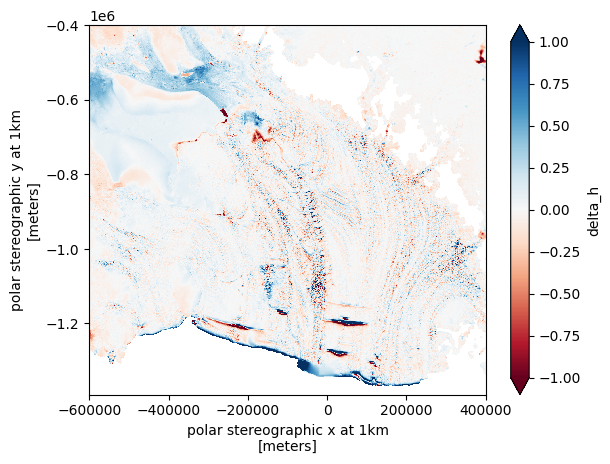

In [25]:
# Extract height change DataArray
dh = ross_icesat2.delta_h

# Approximate year spans for all 6 years
# NOTE: We use nearest neighbour to select time slices, so slight irregularities are OK
year_slices = [
    ("2019-01-01", "2020-01-01"),
    ("2020-01-01", "2021-01-01"), # Note slightly irregular spacing "2020-12-31"
    ("2021-01-01", "2022-01-01"),
    ("2022-01-01", "2023-01-01"),
    ("2023-01-01", "2024-01-01"),
    ("2024-01-01", "2025-01-01"), # Note slightly irregular spacing "2024-12-31"
]

dh_yearly_change = []

for start, end in year_slices:
    dh_start = dh.sel(time = start, method = "nearest")
    dh_end = dh.sel(time = end, method = "nearest")
    # positive denotes ice shelf thickening (growth)
    # change over full year
    dh_change = dh_end - dh_start
    dh_yearly_change.append(dh_change)

# Combine into one DataArray with 'year' dimension
years = np.arange(2019, 2019 + len(year_slices))
dh_yearly_change = xr.concat(dh_yearly_change, dim = "year")
dh_yearly_change = dh_yearly_change.assign_coords(year = years)

# Optional: convert to rate (m yr⁻¹)
dh_rate_yearly = dh_yearly_change

# Mean annual surface elevation change (2019 – 2024)
mean_thickening_rate = dh_rate_yearly.mean("year")

# Plot mean annual thickening rate over all 6 years
mean_thickening_rate.plot(cmap = "RdBu", vmin = -1, vmax = 1)

Interpretation: Here the edge i.e. calcing front has been growing out (before a potential calbing vent which happens at irregular intervals)

# Plot all 6 years: Note inter-year variability

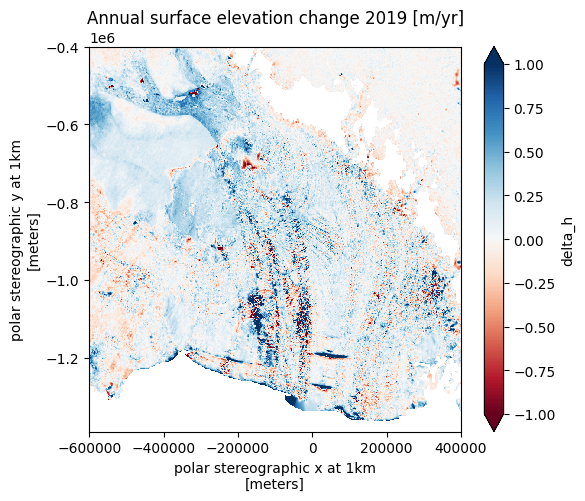

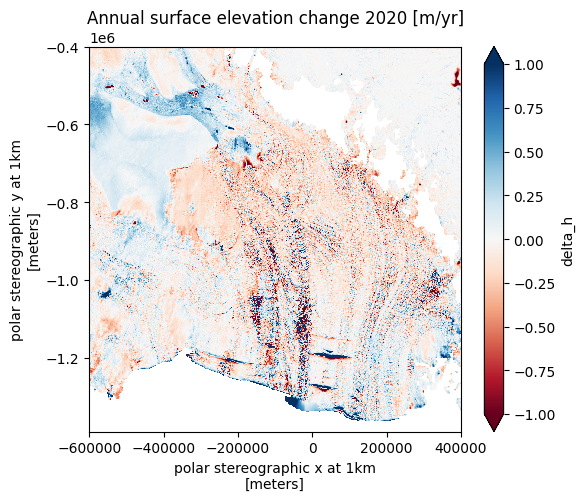

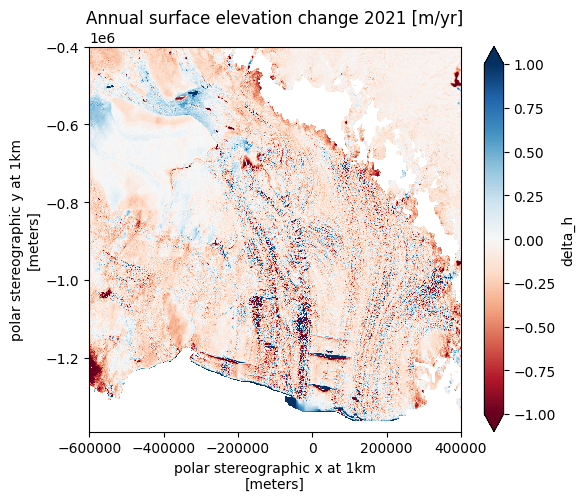

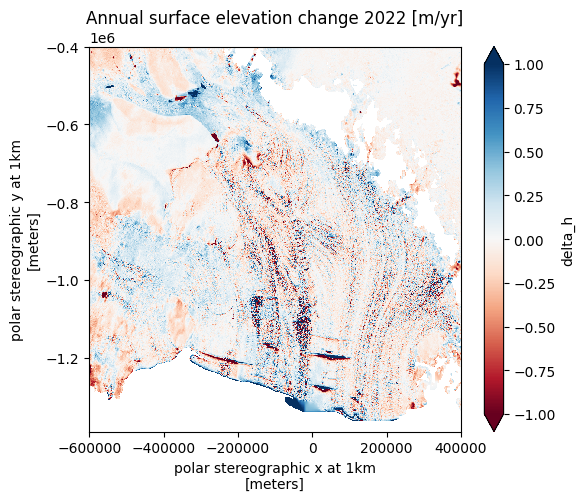

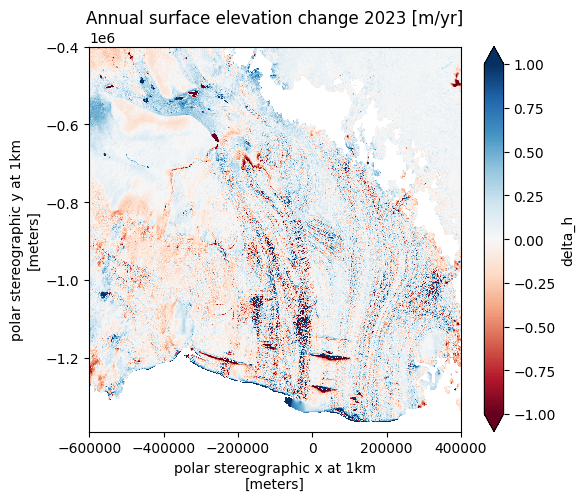

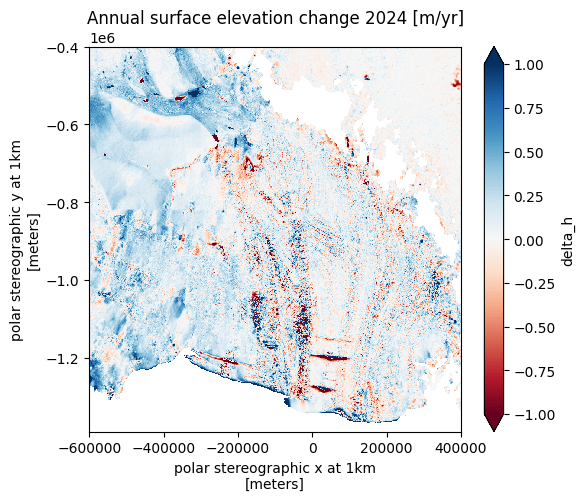

In [26]:
for yr in dh_rate_yearly.year.values:
    plt.figure(figsize = (6,5))
    dh_rate_yearly.sel(year = yr).plot(
        # keep range consistent
        # colorscale: blue = thickening, red = thinning
        cmap = "RdBu", vmin = -1, vmax = 1, robust = True
    )
    plt.title(f"Annual surface elevation change {int(yr)} [m/yr]")
    plt.show()

### Check against second method

Text(0.5, 1.0, 'Mean quarterly height change for 2019 (m)')

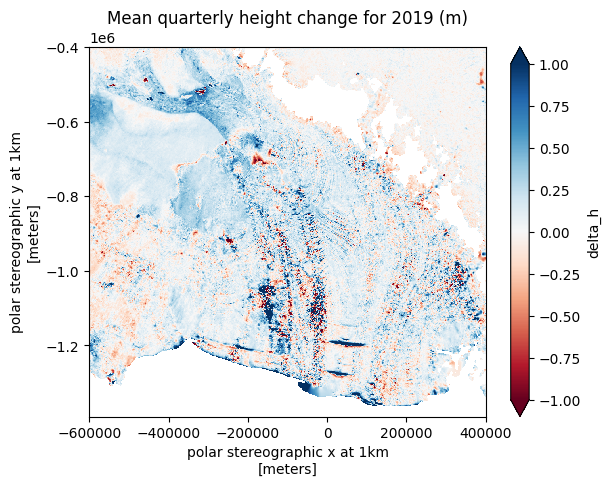

In [27]:
q1 = ross_icesat2.delta_h.sel(time = "2019-04-02").squeeze("time") - ross_icesat2.delta_h.sel(time = "2019-01-01").squeeze("time")
q2 = ross_icesat2.delta_h.sel(time = "2019-07-02").squeeze("time") - ross_icesat2.delta_h.sel(time = "2019-04-02").squeeze("time")
q3 = ross_icesat2.delta_h.sel(time = "2019-10-02").squeeze("time") - ross_icesat2.delta_h.sel(time = "2019-07-02").squeeze("time")
q4 = ross_icesat2.delta_h.sel(time = "2020-01-01").squeeze("time") - ross_icesat2.delta_h.sel(time = "2019-10-02").squeeze("time")

# Add quarters differences
mean_2019 = (q1 + q2 + q3 + q4)

mean_2019.plot(cmap = "RdBu", vmin = -1, vmax = 1)
plt.title("Mean quarterly height change for 2019 (m)")

# Convert surface elevation change to dh/dt via hydrosatic equilibrium

For floating ice shelves in hydrostatic equilibrium:

$\rho_i h_i = \rho_w h_w$

where
- $\rho_i$ is the density of ice (~917 kg m⁻³)
- $\rho_w$ is the density of sea water (~1028 kg m⁻³) 
- $h_i$ is the total ice thickness
- $h_w$ is the submerged ice thickness (draft)

$h_s = h_i - h_w$ expresses that the surface height (height of ice above sea level)

Rearrange: 
$h_i = \frac{h_s}{1 - \frac{\rho_i}{\rho_w}}$

For example, for 10 meters of (floating) ice above sea level, about 90 meters are below sea level. ("only the top of the iceberg")

and 

$\Delta h_i = \frac{\Delta h_{\text{surf}}}{1 - \frac{\rho_i}{\rho_w}}$

Consider: firn

Between 0 and 1 in Rignot.

In [28]:
rho_ice = 917  # kg m⁻³
rho_w = 1028  # kg m⁻³
rho_ratio = rho_ice / rho_w

denominator = 1 - (rho_ice / rho_w)
# thickness change = elevation change / (1 - (rho_ice / rho_w))
# thickness change = elevation change / denominator

surface_thickness_change_example = 1
surface_thickness_change_example / denominator

print(f"Total thickness change is {1/denominator:.2f} times the surface elevation change.")

Total thickness change is 9.26 times the surface elevation change.
